In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 3
despine_trim = True

### Load data and create plotting code that shows the per-bin scRT and CN accuracies of PERT

In [3]:
acc_df = pd.read_csv('scdna_replication_paper/analysis/simulation/all/scRT_accuracies.tsv', sep='\t')

# rename lambda column to avoid conflict with python keyword
acc_df.rename(columns={'lambda': 'lamb'}, inplace=True)

acc_df.head()

,dataset,datatag,alpha,lamb,beta0,beta1,cell_cna_rate,num_clones,method,rep_accuracy,cn_accuracy
0,D1.0,D1,10.0,0.75,1.2,0.0,0.0,1,Kronos,0.943182,NaN
1,D1.0,D1,10.0,0.75,1.2,0.0,0.0,1,PERT clone,0.997884,0.999987
2,D1.0,D1,10.0,0.75,1.2,0.0,0.0,1,PERT comp.,0.997857,0.999991
3,D1.1,D1,10.0,0.75,1.2,0.0,0.0,1,Kronos,0.934858,NaN
4,D1.1,D1,10.0,0.75,1.2,0.0,0.0,1,PERT clone,0.997593,0.999977


In [4]:
def get_methods_cmap():
    cmap = {
        'PERT clone': 'olive',
        'PERT comp.': 'yellowgreen',
        'PERT': 'yellowgreen',
        'Kronos': 'lightcoral',
        'Laks': 'darksalmon',
    }
    return cmap

cn_acc_ylabel = 'per-bin CN acc.'
rep_acc_ylabel = 'per-bin rep acc.'


def violins_with_pvals(df, x, y, hue, ax, box_pairs, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    """ Create a violinplot with p-values annotated. """
    palette = get_methods_cmap()
    sns.boxplot(data=df, x=x, y=y, hue=hue, ax=ax, palette=palette, linewidth=0.5, fliersize=1, hue_order=hue_order)
    add_stat_annotation(ax, data=df, x=x, y=y, hue=hue,
                        box_pairs=box_pairs, test=test,
                        text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)


def plot_cna_rate_rep_acc(df, ax, n=1, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    ''' Plot the replications state accuracy vs cna rate at a fixed number of clones (n). '''
    x = "cell_cna_rate"
    y = "rep_accuracy"
    hue = "method"
    temp_df = df.query('alpha==10.0').query('lamb==0.75').query('num_clones=={}'.format(n)).query('beta0==1.2')
    box_pairs = [
        ((0.05, "PERT clone"), (0.05, "PERT comp.")),
        ((0.02, "PERT clone"), (0.02, "PERT comp.")),
        ((0.05, "Kronos"), (0.05, "PERT comp.")),
        ((0.05, "PERT clone"), (0.05, "Kronos")),
        ((0.02, "Kronos"), (0.02, "PERT comp.")),
        ((0.02, "PERT clone"), (0.02, "Kronos")),
        ((0.00, "PERT comp."), (0.00, "PERT clone")),
        ((0.00, "PERT comp."), (0.00, "Kronos")),
        ((0.00, "Kronos"), (0.00, "PERT clone")),
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test, text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)
    ax.set_title('# of clones={}'.format(n))
    ax.set_xlabel('cell CNA rate')
    ax.set_ylabel(rep_acc_ylabel)
    ax.legend().set_visible(False)
    return ax


def plot_cna_rate_cn_acc(df, ax, n=1, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    ''' Plot the cn accuracy vs cna rate at a fixed number of clones (n). '''
    x = "cell_cna_rate"
    y = "cn_accuracy"
    hue = "method"
    temp_df = df.query('alpha==10.0').query('lamb==0.75').query('num_clones=={}'.format(n)).query('beta0==1.2')
    box_pairs = [
        ((0.05, "PERT clone"), (0.05, "PERT comp.")),
        ((0.02, "PERT clone"), (0.02, "PERT comp.")),
        ((0.00, "PERT clone"), (0.00, "PERT comp.")),
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)
    ax.set_title('# of clones={}'.format(n))
    ax.set_xlabel('cell CNA rate')
    ax.set_ylabel(cn_acc_ylabel)
    ax.legend().set_visible(False)
    return ax


def plot_clone_effect_rep_acc(df, ax, rate=0.02, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    ''' Plot the replication accuracy vs number of clones at a fixed cell cna rate. '''
    x = "num_clones"
    y = "rep_accuracy"
    hue = "method"
    temp_df = df.query('alpha==10.0').query('lamb==0.75').query('cell_cna_rate=={}'.format(rate)).query('num_clones<4').query('beta0==1.2')
    box_pairs = [
        ((3, "Kronos"), (3, "PERT comp.")),
        ((3, "PERT clone"), (3, "Kronos")),
        ((3, "PERT clone"), (3, "PERT comp.")),
        ((1, "Kronos"), (1, "PERT comp.")),
        ((1, "PERT clone"), (1, "Kronos")),
        ((1, "PERT clone"), (1, "PERT comp.")),
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)
    ax.set_title('Cell CNA rate={}'.format(rate))
    ax.set_xlabel('# of clones')
    ax.set_ylabel(rep_acc_ylabel)
    ax.legend().set_visible(False)
    return ax


def plot_clone_effect_cn_acc(df, ax, rate=0.02, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    ''' Plot the CN accuracy vs number of clones at a fixed cell cna rate. '''
    x = "num_clones"
    y = "cn_accuracy"
    hue = "method"
    temp_df = df.query('alpha==10.0').query('lamb==0.75').query('cell_cna_rate=={}'.format(rate)).query('num_clones<4').query('beta0==1.2')
    box_pairs = [
        ((3, "PERT clone"), (3, "PERT comp.")),
        ((1, "PERT clone"), (1, "PERT comp.")),
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)
    ax.set_title('Cell CNA rate={}'.format(rate))
    ax.set_xlabel('# of clones')
    ax.set_ylabel(cn_acc_ylabel)
    ax.legend().set_visible(False)
    return ax


def plot_alpha_effect_cn_acc(df, ax, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    ''' Plot the cn accuracy vs alpha where the hue is cell cna rate. '''
    x = "alpha"
    y = "cn_accuracy"
    hue = "method"
    temp_df = df.query('lamb==0.75').query('beta0==1.2').query('num_clones<4').query('cell_cna_rate==0.02')
    box_pairs = [
        ((10.0, 'PERT comp.'), (10.0, 'PERT clone')),
        ((5.0, 'PERT comp.'), (5.0, 'PERT clone')),
        ((15.0, 'PERT comp.'), (15.0, 'PERT clone'))
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)
    # ax.set_title('Sweep across alpha')
    ax.set_ylabel(cn_acc_ylabel)
    ax.set_xlabel('alpha')
    ax.legend().set_visible(False)


def plot_alpha_effect_rep_acc(df, ax, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    ''' Plot the rep accuracy vs alpha where the hue is cell cna rate. '''
    x = "alpha"
    y = "rep_accuracy"
    hue = "method"
    temp_df = df.query('lamb==0.75').query('beta0==1.2').query('num_clones<4').query('cell_cna_rate==0.02')
    box_pairs = [
        ((10.0, 'PERT comp.'), (10.0, 'PERT clone')),
        ((5.0, 'PERT comp.'), (5.0, 'PERT clone')),
        ((15.0, 'PERT comp.'), (15.0, 'PERT clone')),
        ((10.0, 'PERT comp.'), (10.0, 'Kronos')),
        ((5.0, 'PERT comp.'), (5.0, 'Kronos')),
        ((15.0, 'PERT comp.'), (15.0, 'Kronos')),
        ((10.0, 'PERT clone'), (10.0, 'Kronos')),
        ((5.0, 'PERT clone'), (5.0, 'Kronos')),
        ((15.0, 'PERT clone'), (15.0, 'Kronos'))
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)
    # ax.set_title('Sweep across alpha')
    ax.set_ylabel(rep_acc_ylabel)
    ax.set_xlabel('alpha')
    ax.legend().set_visible(False)


def plot_lambda_effect_cn_acc(df, ax, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    ''' Plot the copy number accuracy vs lambda where the hue is cell cna rate. '''
    x = "lamb"
    y = "cn_accuracy"
    hue = "method"
    temp_df = df.query('cell_cna_rate==0').query('num_clones==1').query('alpha==10.0').query('beta0==1.2')
    box_pairs = [
        ((0.5, 'PERT clone'), (0.5, 'PERT comp.')),
        ((0.6, 'PERT clone'), (0.6, 'PERT comp.')),
        ((0.75, 'PERT clone'), (0.75, 'PERT comp.')),
        ((0.9, 'PERT clone'), (0.9, 'PERT comp.')),
        ((0.99, 'PERT clone'), (0.99, 'PERT comp.'))
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)
    ax.set_xlabel('lambda')
    # ax.set_title('Sweep across lambda')
    ax.set_ylabel(cn_acc_ylabel)
    ax.legend().set_visible(False)


def plot_lambda_effect_rep_acc(df, ax, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    ''' Plot the replication accuracy vs lambda where the hue is the method. '''
    x = "lamb"
    y = "rep_accuracy"
    hue = "method"
    temp_df = df.query('cell_cna_rate==0').query('num_clones==1').query('alpha==10.0').query('beta0==1.2')
    box_pairs = [
        ((0.5, 'PERT clone'), (0.5, 'PERT comp.')),
        ((0.6, 'PERT clone'), (0.6, 'PERT comp.')),
        ((0.75, 'PERT clone'), (0.75, 'PERT comp.')),
        ((0.9, 'PERT clone'), (0.9, 'PERT comp.')),
        ((0.99, 'PERT clone'), (0.99, 'PERT comp.')),
        ((0.5, 'PERT clone'), (0.5, 'Kronos')),
        ((0.6, 'PERT clone'), (0.6, 'Kronos')),
        ((0.75, 'PERT clone'), (0.75, 'Kronos')),
        ((0.9, 'PERT clone'), (0.9, 'Kronos')),
        ((0.99, 'PERT clone'), (0.99, 'Kronos')),
        ((0.5, 'Kronos'), (0.5, 'PERT comp.')),
        ((0.6, 'Kronos'), (0.6, 'PERT comp.')),
        ((0.75, 'Kronos'), (0.75, 'PERT comp.')),
        ((0.9, 'Kronos'), (0.9, 'PERT comp.')),
        ((0.99, 'Kronos'), (0.99, 'PERT comp.'))
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)
    ax.set_xlabel('lambda')
    # ax.set_title('Sweep across lambda')
    ax.set_ylabel(rep_acc_ylabel)
    ax.legend().set_visible(False)


def plot_gc_bias_effect_cn_acc(df, ax, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    ''' Plot the phase accuracy vs GC bias coefficients in datasets with all other params fixed. '''
    x = "beta0"
    y = "cn_accuracy"
    hue = "method"
    temp_df = df.query('cell_cna_rate==0.0').query('num_clones==1').query('alpha==10.0').query('lamb==0.75')
    box_pairs = [
        ((1.2, 'PERT comp.'), (1.2, 'PERT clone')),
        ((-1.2, 'PERT comp.'), (-1.2, 'PERT clone'))
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)
    # ax.set_title('Sweep across GC bias coefficients')
    ax.set_ylabel(cn_acc_ylabel)
    ax.set_xlabel('beta0 (GC bias slope)')
    ax.legend().set_visible(False)


def plot_gc_bias_effect_rep_acc(df, ax, test='t-test_ind', text_format='star', loc='inside', verbose=0, hue_order=None):
    ''' Plot the replication accuracy vs GC bias coefficients in datasets with all other params fixed. '''
    x = "beta0"
    y = "rep_accuracy"
    hue = "method"
    temp_df = df.query('cell_cna_rate==0.0').query('num_clones==1').query('alpha==10.0').query('lamb==0.75')
    box_pairs = [
        ((1.2, 'PERT comp.'), (1.2, 'PERT clone')),
        ((-1.2, 'PERT comp.'), (-1.2, 'PERT clone')),
        ((1.2, 'PERT comp.'), (1.2, 'Kronos')),
        ((-1.2, 'PERT comp.'), (-1.2, 'Kronos')),
        ((1.2, 'PERT clone'), (1.2, 'Kronos')),
        ((-1.2, 'PERT clone'), (-1.2, 'Kronos'))
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose, hue_order=hue_order)
    # ax.set_title('GC bias sweep')
    ax.set_ylabel(rep_acc_ylabel)
    ax.set_xlabel('beta0 (GC bias slope)')
    ax.legend().set_visible(False)

In [5]:
def format_yaxes(ax, r):
    # set all the subplots to have the same y limits
    for i in range(2):
        for j in range(5):
            if i==1 and j==1:
                continue
            else:
                yticks = ax[i+r, j].get_yticks()
                yticks = [a for a in yticks if a <= 1 and a>=0]
                yticklabels = [str(a.round(2)) for a in yticks]
                ax[i+r, j].set_yticks(yticks)
                ax[i+r, j].set_yticklabels(yticklabels)
                sns.despine(ax=ax[i+r, j], offset=despine_offset, trim=despine_trim)
                if j>0:
                    ax[i+r, j].set_ylabel('')
            
    # remove the ylabels for all but the leftmost plots
    for i in range(2):
        for j in range(1, 5):
            if i!=1 and j!=1:
                ax[i+r, j].set_ylabel('')


def plot_param_sweep_rep_acc(df, ax, r=0):
    """ Figure showing replication accuracy parameter sweep across num_clones and cell_cna_rate """
    # set the hue order to be the same for all plots
    hue_order = ['PERT comp.', 'PERT clone', 'Kronos']

    # top row shows accuracy at predicting replication states
    # show effect of varying cna rate at fixed number of clones
    plot_cna_rate_rep_acc(df, ax[0+r, 0], n=1, hue_order=hue_order)
    plot_cna_rate_rep_acc(df, ax[0+r, 1], n=3, hue_order=hue_order)
    # show effect of varying number of clones at fixed cna rates
    plot_clone_effect_rep_acc(df, ax[0+r, 2], rate=0.0, hue_order=hue_order)
    plot_clone_effect_rep_acc(df, ax[0+r, 3], rate=0.02, hue_order=hue_order)
    plot_clone_effect_rep_acc(df, ax[0+r, 4], rate=0.05, hue_order=hue_order)

    # barplots of phase accuracies for all simulated datasets
    # barplots of phase accuracies for all simulated datasets
    polyclonal_order = ['P{}'.format(i) for i in range(1, 12)]
    diploid_order = ['D{}'.format(i) for i in range(1, 11)]
    # join diploid order to polyclonal order
    xodrder = diploid_order + polyclonal_order
    sns.barplot(
        data=df, x='datatag', y='rep_accuracy', hue='method', hue_order=hue_order, order=xodrder,
        ax=ax[1+r, 0], palette=get_methods_cmap(), saturation=1, errwidth=1
    )
    ax[1+r, 0].set_ylabel(rep_acc_ylabel)
    ax[1+r, 0].legend(loc='lower left')
    # ax[1+r, 0].set_title('All simulated datasets')

    # plot the effect of varying alpha
    plot_alpha_effect_rep_acc(df, ax[1+r, 2], hue_order=hue_order)

    # plot the effect of varying lambda
    plot_lambda_effect_rep_acc(df, ax[1+r, 3], hue_order=hue_order)
    
    # plot the effect of varying GC bias
    plot_gc_bias_effect_rep_acc(df, ax[1+r, 4], hue_order=hue_order)

    # format the y-axis of all plots
    format_yaxes(ax, r)

    # rotate the tick labels on the barplots after despining
    ax[1+r, 0].tick_params(axis='x', rotation=90)


def plot_param_sweep_cn_acc(df, ax, r=2):
    """ Figure showing copy number accuracy parameter sweep across num_clones and cell_cna_rate """
    # remove all rows of df where method=='Kronos' since it doesn't predict CN states
    df = df.query('method!="Kronos"')

    # hue_order
    hue_order = ['PERT comp.', 'PERT clone']

    # top row shows accuracy at predicting replication states
    # show effect of varying cna rate at fixed number of clones
    plot_cna_rate_cn_acc(df, ax[0+r, 0], n=1, hue_order=hue_order)
    plot_cna_rate_cn_acc(df, ax[0+r, 1], n=3, hue_order=hue_order)
    # show effect of varying number of clones at fixed cna rates
    plot_clone_effect_cn_acc(df, ax[0+r, 2], rate=0.0, hue_order=hue_order)
    plot_clone_effect_cn_acc(df, ax[0+r, 3], rate=0.02, hue_order=hue_order)
    plot_clone_effect_cn_acc(df, ax[0+r, 4], rate=0.05, hue_order=hue_order)

    # barplots of phase accuracies for all simulated datasets
    polyclonal_order = ['P{}'.format(i) for i in range(1, 12)]
    diploid_order = ['D{}'.format(i) for i in range(1, 11)]
    # join diploid order to polyclonal order
    xodrder = diploid_order + polyclonal_order
    sns.barplot(
        data=df, x='datatag', y='cn_accuracy', hue='method', hue_order=hue_order, order=xodrder,
        ax=ax[1+r, 0], palette=get_methods_cmap(), saturation=1, errwidth=1
    )
    ax[1+r, 0].set_ylabel(cn_acc_ylabel)
    ax[1+r, 0].legend(loc='lower left')
    # ax[1+r, 0].set_title('All simulated datasets')

    # plot the effect of varying alpha
    plot_alpha_effect_cn_acc(df, ax[1+r, 2], hue_order=hue_order)

    # plot the effect of varying lambda
    plot_lambda_effect_cn_acc(df, ax[1+r, 3], hue_order=hue_order)
    
    # plot the effect of varying GC bias
    plot_gc_bias_effect_cn_acc(df, ax[1+r, 4], hue_order=hue_order)

    # format the y-axis of all plots
    format_yaxes(ax, r)
    
    # rotate the tick labels on the barplots after despining
    ax[1+r, 0].tick_params(axis='x', rotation=90)


### Load and plot data showing the per-cell phase accuracies for PERT vs the Laks et al cell cycle classifier 

In [6]:
df = pd.read_csv('scdna_replication_paper/analysis/simulation/all/phase_accuracies.tsv', sep='\t')

df['PERT_phase'] = df['PERT_phase'].astype(str)
df['true_phase'] = df['true_phase'].astype(str)
df['laks_phase'] = df['laks_phase'].astype(str)
df['cell_id'] = df['cell_id'].astype(str)

# rename the lambda column to lambd to avoid conflict with python keyword
df.rename(columns={'lambda': 'lamb'}, inplace=True)

# melt `PERT_phase_acc` and `laks_phase_acc` into a single column `phase_acc`
# and 'PERT_phase' and 'laks_phase' into a single column `pred_phase`
# where the method is noted in a new column `method`
df = pd.melt(df, 
    id_vars=[col for col in df.columns if not col.endswith('_phase_acc')],
    value_vars=['PERT_phase_acc', 'laks_phase_acc'], var_name='method', value_name='phase_acc')

# rename the method column to remove the '_phase_acc' suffix
df['method'] = df['method'].str.replace('_phase_acc', '')

# create a new column named 'predicted_phase' that is the same as 'PERT_phase' if 'method' is 'PERT', 'laks_phase' if the method is 'laks'
df['predicted_phase'] = np.where(df['method'] == 'PERT', df['PERT_phase'], df['laks_phase'])

# create a new column named 'phase_class' which says whether the 
# given prediction is a true positive, false positive, true negative, or false negative
df['phase_class'] = 'None'
for i, row in df.iterrows():
    if row['predicted_phase'] == row['true_phase'] and row['true_phase'] == 'S':
        df.at[i, 'phase_class'] = 'TP'
    elif row['predicted_phase'] == row['true_phase'] and row['true_phase'] == 'G1/2':
        df.at[i, 'phase_class'] = 'TN'
    elif row['predicted_phase'] != row['true_phase'] and row['true_phase'] == 'S':
        df.at[i, 'phase_class'] = 'FN'
    elif row['predicted_phase'] != row['true_phase'] and row['true_phase'] == 'G1/2':
        df.at[i, 'phase_class'] = 'FP'

# drop the pert_phase and laks_phase columns
df.drop(columns=['PERT_phase', 'laks_phase'], inplace=True)

# fill missing true_cell_frac_rep values with 0.0 as these are G1/2 cells with no replicated bins
df['true_cell_frac_rep'].fillna(0.0, inplace=True)

# rename 'LowQual' entries in the 'predicted_phase' column to 'LQ'
df['predicted_phase'] = df['predicted_phase'].str.replace('LowQual', 'LQ')

# rename method values that are 'laks' to 'Laks'
df['method'] = df['method'].str.replace('laks', 'Laks')

df.head()

,cell_id,true_phase,true_cell_frac_rep,cell_frac_rep,datatag,dataset,alpha,lamb,beta0,beta1,cell_cna_rate,num_clones,method,phase_acc,predicted_phase,phase_class
0,cell_S_0,S,0.083287,0.078291,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
1,cell_S_1,S,0.100715,0.094510,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
2,cell_S_10,S,0.176848,0.163755,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
3,cell_S_100,S,0.810677,0.804117,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
4,cell_S_101,S,0.594019,0.570805,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP


In [7]:
phase_acc_ylabel = 'per-cell phase acc.'

def plot_cna_rate_phase_acc(df, ax, n=1, test='t-test_ind', text_format='star', loc='inside', verbose=0):
    ''' Plot the phase accuracy vs cna rate at a fixed number of clones (n). '''
    x = "cell_cna_rate"
    y = "phase_acc"
    hue = "method"
    temp_df = df.query('alpha==10.0').query('lamb==0.75').query('num_clones=={}'.format(n)).query('beta0==1.2')
    box_pairs = [
        ((0.02, 'PERT'), (0.02, 'Laks')),
        ((0.00, 'PERT'), (0.00, 'Laks')),
        ((0.05, 'PERT'), (0.05, 'Laks'))
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test, text_format=text_format, loc=loc, verbose=verbose)
    ax.set_title('# of clones={}'.format(n))
    ax.set_ylabel(phase_acc_ylabel)
    ax.set_xlabel('cell CNA rate')
    ax.legend().set_visible(False)


def plot_clone_effect_phase_acc(df, ax, rate=0.02, test='t-test_ind', text_format='star', loc='inside', verbose=0):
    ''' Plot the phase accuracy vs number of clones at a fixed cell cna rate. '''
    x = "num_clones"
    y = "phase_acc"
    hue = "method"
    temp_df = df.query('alpha==10.0').query('lamb==0.75').query('cell_cna_rate=={}'.format(rate)).query('num_clones<4').query('beta0==1.2')
    box_pairs = [
        ((1, 'PERT'), (1, 'Laks')),
        ((3, 'PERT'), (3, 'Laks'))
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose)
    ax.set_title('Cell CNA rate={}'.format(rate))
    ax.set_ylabel(phase_acc_ylabel)
    ax.set_xlabel('# of clones')
    ax.legend().set_visible(False)


def plot_alpha_effect(df, ax, test='t-test_ind', text_format='star', loc='inside', verbose=0):
    ''' Plot the phase accuracy vs alpha where the hue is cell cna rate. '''
    x = "alpha"
    y = "phase_acc"
    hue = "method"
    temp_df = df.query('lamb==0.75').query('beta0==1.2').query('num_clones<4').query('cell_cna_rate==0.02')
    box_pairs = [
        ((10.0, 'PERT'), (10.0, 'Laks')),
        ((5.0, 'PERT'), (5.0, 'Laks')),
        ((15.0, 'PERT'), (15.0, 'Laks'))
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose)
    ax.set_ylabel(phase_acc_ylabel)
    ax.set_xlabel('alpha')
    ax.legend().set_visible(False)


def plot_lambda_effect(df, ax, test='t-test_ind', text_format='star', loc='inside', verbose=0):
    ''' Plot the phase accuracy vs lambda where the hue is cell cna rate. '''
    x = "lamb"
    y = "phase_acc"
    hue = "method"
    temp_df = df.query('cell_cna_rate==0').query('num_clones==1').query('alpha==10.0').query('beta0==1.2')
    box_pairs = [
        ((0.5, 'Laks'), (0.5, 'PERT')),
        ((0.6, 'Laks'), (0.6, 'PERT')),
        ((0.75, 'Laks'), (0.75, 'PERT')),
        ((0.9, 'Laks'), (0.9, 'PERT')),
        ((0.99, 'Laks'), (0.99, 'PERT'))
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose)
    ax.set_xlabel('lambda')
    ax.set_ylabel(phase_acc_ylabel)
    ax.legend().set_visible(False)


def plot_gc_bias_effect(df, ax, test='t-test_ind', text_format='star', loc='inside', verbose=0):
    ''' Plot the phase accuracy vs GC bias coefficients in datasets with all other params fixed. '''
    x = "beta0"
    y = "phase_acc"
    hue = "method"
    temp_df = df.query('cell_cna_rate==0.0').query('num_clones==1').query('alpha==10.0').query('lamb==0.75')
    box_pairs = [
        ((1.2, 'PERT'), (1.2, 'Laks')),
        ((-1.2, 'PERT'), (-1.2, 'Laks')),
    ]
    violins_with_pvals(temp_df, x, y, hue, ax, box_pairs, test=test,
                       text_format=text_format, loc=loc, verbose=verbose)
    ax.set_ylabel(phase_acc_ylabel)
    ax.set_xlabel('beta0 (GC bias slope)')
    ax.legend().set_visible(False)

In [8]:
def plot_param_sweep(df, ax, r=4):
    """ Figure showing phase accuracy parameter sweep across num_clones and cell_cna_rate """

    # top row shows accuracy at predicting replication states
    # show effect of varying cna rate at fixed number of clones
    plot_cna_rate_phase_acc(df, ax[0+r, 0], n=1)
    plot_cna_rate_phase_acc(df, ax[0+r, 1], n=3)
    # show effect of varying number of clones at fixed cna rates
    plot_clone_effect_phase_acc(df, ax[0+r, 2], rate=0.0)
    plot_clone_effect_phase_acc(df, ax[0+r, 3], rate=0.02)
    plot_clone_effect_phase_acc(df, ax[0+r, 4], rate=0.05)

    # barplots of phase accuracies for all simulated datasets
    polyclonal_order = ['P{}'.format(i) for i in range(1, 12)]
    diploid_order = ['D{}'.format(i) for i in range(1, 11)]
    # join diploid order to polyclonal order
    xodrder = diploid_order + polyclonal_order
    sns.barplot(
        data=df, x='datatag', y='phase_acc', hue='method', order=xodrder,
        ax=ax[1+r, 0], palette=get_methods_cmap(), saturation=1, errwidth=1
    )
    ax[1+r, 0].set_ylabel(phase_acc_ylabel)
    ax[1+r, 0].legend(loc='lower left')

    # plot the effect of varying alpha
    plot_alpha_effect(df, ax[1+r, 2])

    # plot the effect of varying lambda
    plot_lambda_effect(df, ax[1+r, 3])
    
    # plot the effect of varying GC bias
    plot_gc_bias_effect(df, ax[1+r, 4])

    # format the y-axis of all plots
    format_yaxes(ax, r)
    
    # rotate the tick labels on the barplots after despining
    ax[1+r, 0].tick_params(axis='x', rotation=90)

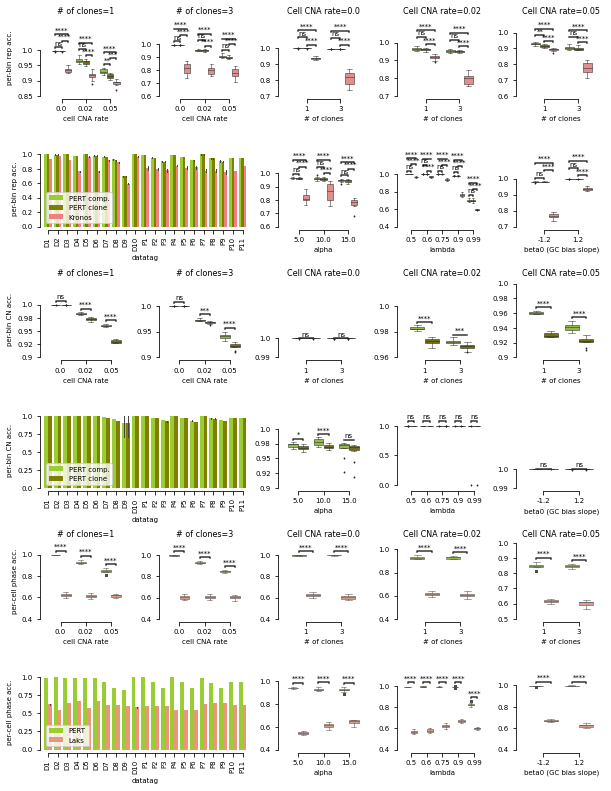

In [9]:
# plot the entire figure
fig, ax = plt.subplots(6, 5, figsize=(8.5, 11), tight_layout=True)

# merge the left two subplots in the 2nd, 4th and 6th rows
for row in [1, 3, 5]:
    gs = ax[row, 0].get_gridspec()
    for a in ax[row, :2]:
        a.remove()
    ax[row, 0] = fig.add_subplot(gs[row, 0:2])

# plot the per-bin replication accuracies starting in the top row
plot_param_sweep_rep_acc(acc_df, ax, r=0)

# plot the per-bin copy number accuracies starting in the 3rd row
plot_param_sweep_cn_acc(acc_df, ax, r=2)

# plot the per-cell phase accuracies starting in the 5th row
plot_param_sweep(df, ax, r=4)

fig.savefig('scdna_replication_paper/manuscript/supplementary_figs/figS2.pdf', dpi=300, bbox_inches='tight')

plt.show()